**Корректность проверена на Python 3.7:**
+ pandas 0.23.0
+ numpy 1.14.5
+ scipy 1.1.0
+ statsmodels 0.9.0

# Продажи австралийского вина

Известны ежемесячные продажи австралийского вина в тысячах литров с января 1980 по июль 1995, необходимо построить прогноз на следующие три года.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


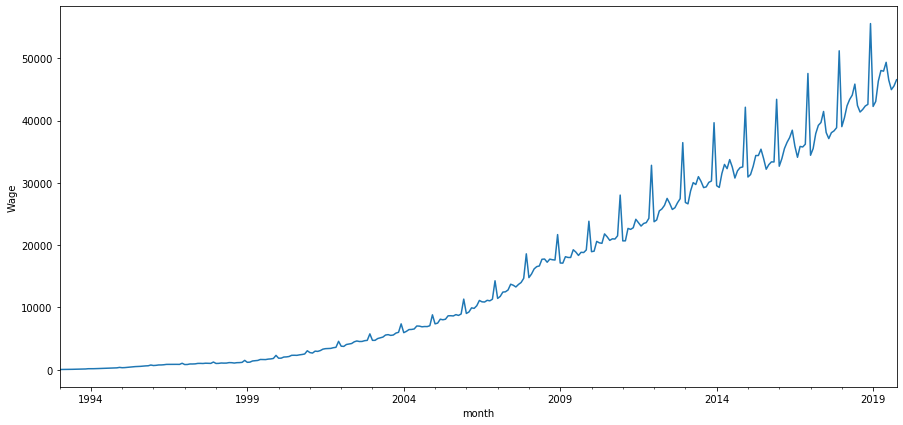

In [2]:
WAG = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
WAG.columns = ['wage']
plt.figure(figsize(15,7))
WAG.wage.plot()
plt.ylabel('Wage')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

NameError: name 'wine' is not defined

<Figure size 1080x720 with 0 Axes>

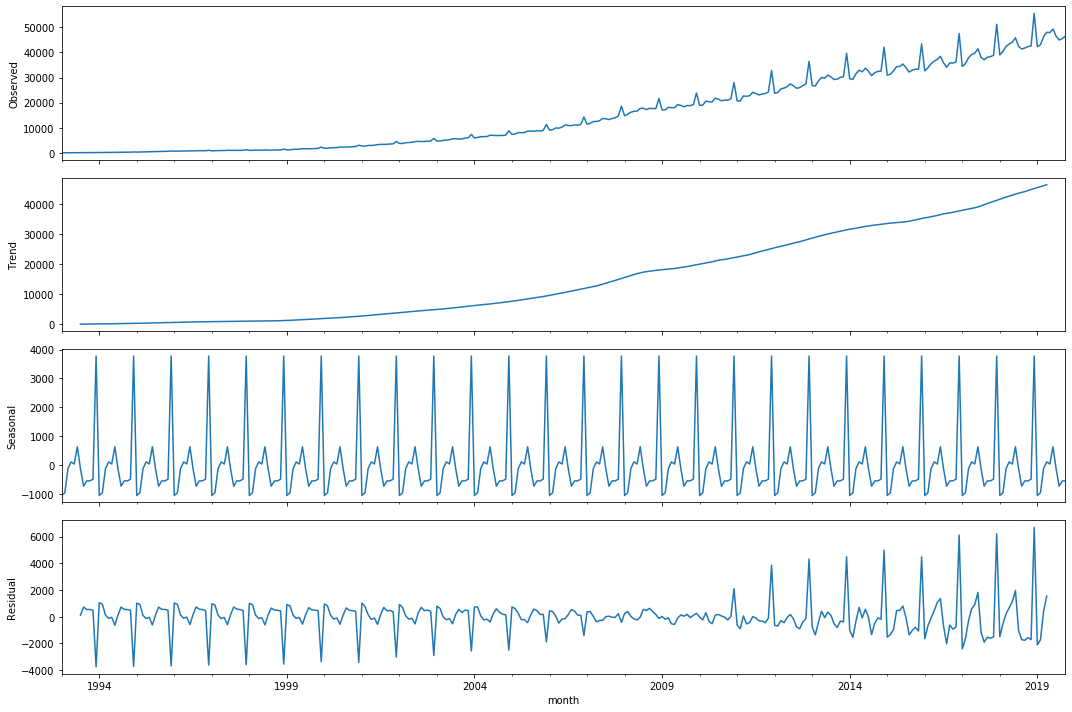

In [3]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(WAG.wage).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wine.sales)[1])
plt.show()

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.288315


NameError: name 'wine' is not defined

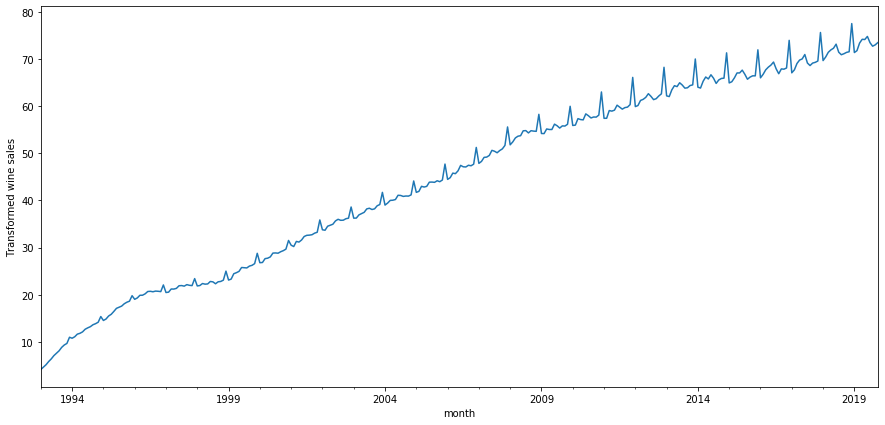

In [4]:
WAG['wage_box'], lmbda = stats.boxcox(WAG.wage)
plt.figure(figsize(15,7))
WAG.wage_box.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wine.sales_box)[1])

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.123755


<Figure size 1080x720 with 0 Axes>

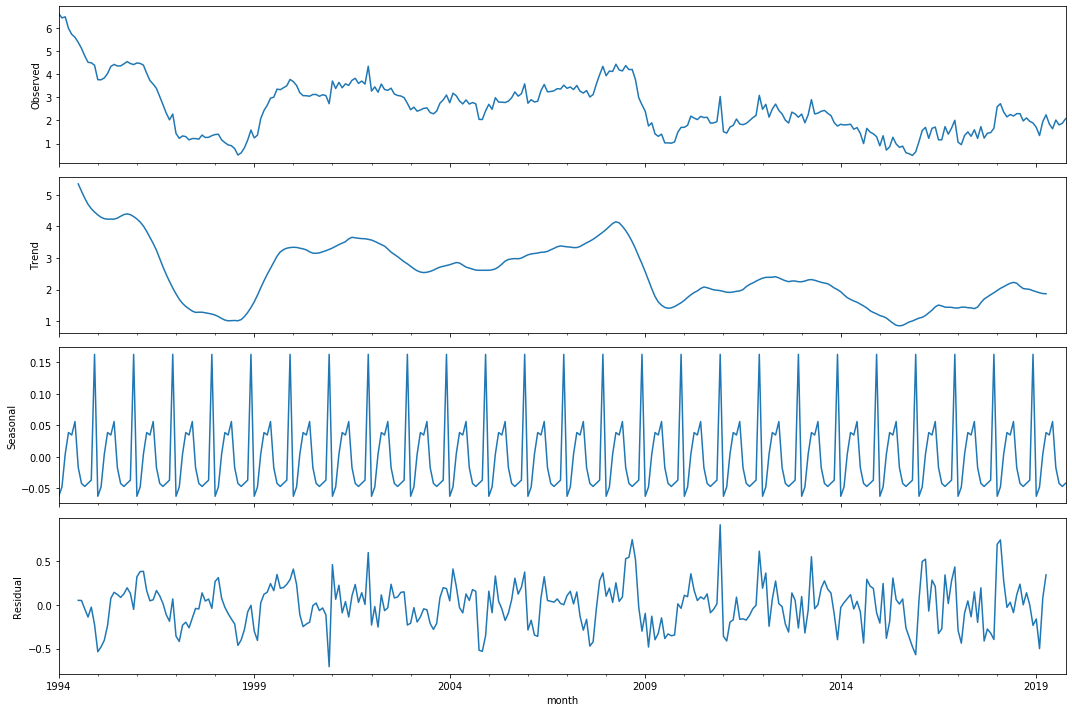

In [5]:
WAG['wage_box_diff'] = WAG.wage_box - WAG.wage_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(WAG.wage_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(WAG.wage_box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

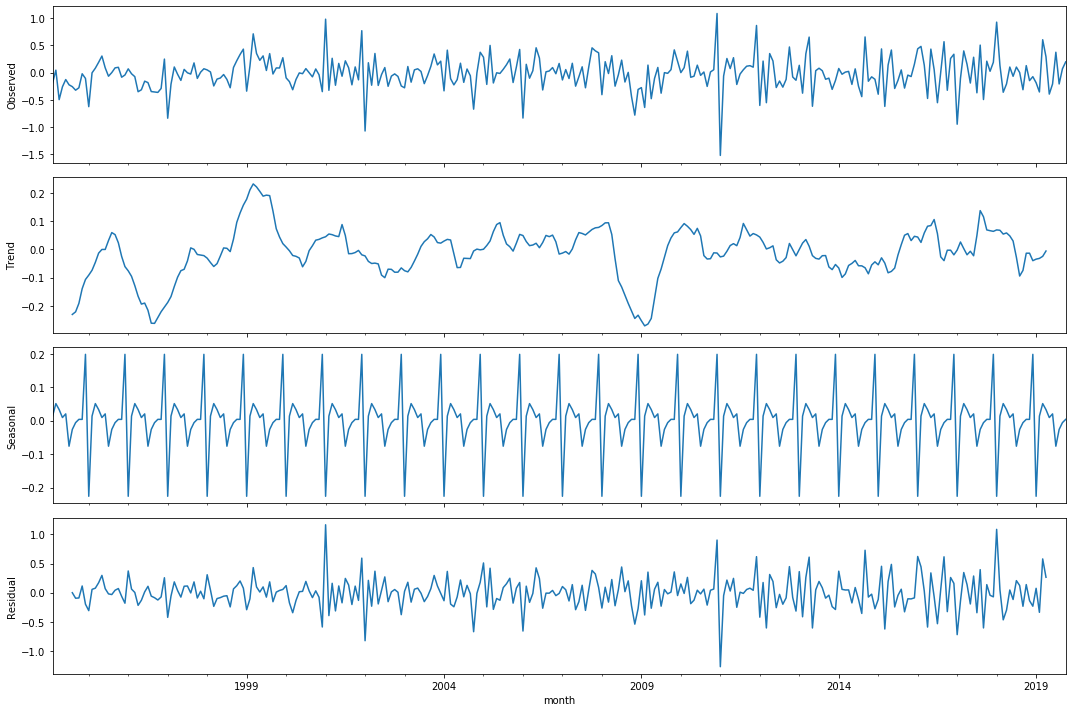

In [6]:
WAG['wage_box_diff2'] = WAG.wage_box_diff - WAG.wage_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(WAG.wage_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(WAG.wage_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

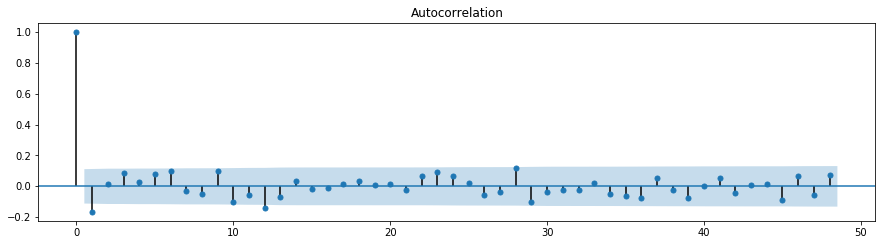

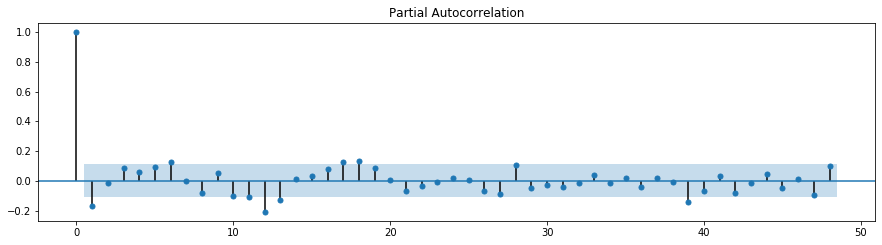

In [7]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(WAG.wage_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(WAG.wage_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=2, P=1, p=4

In [8]:
ps = range(0, 12)
d=1
qs = range(0, 11)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [9]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

528

In [ ]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(WAG.wage_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Если в предыдущей ячейке возникает ошибка, убедитесь, что обновили statsmodels до версии не меньше 0.8.0rc1.

In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

Лучшая модель:

In [ ]:
print(best_model.summary())

Её остатки:

In [ ]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

In [ ]:
WAG['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
WAG.wage.plot()
WAG.model[13:].plot(color='r')
plt.ylabel('Wage')
pylab.show()

### Прогноз

In [ ]:
WAG2 = WAG[['wage']]
date_list = [datetime.datetime.strptime("2019-11-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns=WAG2.columns)
WAG2 = pd.concat([WAG2, future])
WAG2['forecast'] = invboxcox(best_model.predict(start=322, end=358), lmbda)

plt.figure(figsize(15,7))
WAG2.wage.plot()
WAG2.forecast.plot(color='r')
plt.ylabel('Wage')
pylab.show()

In [ ]:
WAG2.tail(48)